In [8]:
using CairoMakie
using JLD2
using Printf

In [3]:
diag_file = jldopen("/scratch/nad9961/twolayer_rays/59310910/diagnostics.jld2")

packet_file1 = jldopen("/scratch/nad9961/twolayer_rays/59310910/packets.000000.jld2")
packet_file2 = jldopen("/scratch/nad9961/twolayer_rays/59310910/packets.000001.jld2")

JLDFile /scratch/nad9961/twolayer_rays/59310910/packets.000001.jld2 (read-only)
 └─📂 p
    ├─📂 g
    │  ├─🔢 4484326
    │  ├─🔢 4484733
    │  ├─🔢 4485140
    │  ├─🔢 4485547
    │  ├─🔢 4485954
    │  ├─🔢 4486361
    │  └─ ⋯ (994 more entries)
    └─ ⋯ (4 more entries)

In [55]:
directory = "/scratch/nad9961/swqg/58025661/20"
#directory = "/scratch/nad9961/swqg/59389740/7/"

Nqg_snaps = count_key_snapshots(directory, "qgsw")
t1, _, _, uh1, vh1, _ = load_qgswh_snapshot(directory, grid, Nqg_snaps)
u1 = irfft(uh1, grid.nx)
v1 = irfft(vh1, grid.nx)
println(sum(u1.^2 + v1.^2))

N2L_snaps = count_key_snapshots("/scratch/nad9961/twolayer_rays/59310910", "2Lqg")
t2, _, ψh = load_2L_snapshot("/scratch/nad9961/twolayer_rays/59310910", grid, params, N2L_snaps)
uth2 = -1im * grid.l  .* @views(ψh[:,:,1] + ψh[:,:,2])
vth2 =  1im * grid.kr .* @views(ψh[:,:,1] + ψh[:,:,2])

u2 = irfft(uth2, grid.nx)
v2 = irfft(vth2, grid.nx)
println(sum(u2.^2 + v2.^2))

5531.883025583608
5579.838047206801


In [34]:
using FourierFlows
using FourierFlows: parsevalsum
include("AnalysisUtils.jl")

Nqg_snaps = count_key_snapshots("/scratch/nad9961/twolayer_rays/59310910", "2Lqg")
params = load_2L_qg_params("/scratch/nad9961/twolayer_rays/59310910")
grid = TwoDGrid(; nx=512, Lx=2π)
times = zeros(Nqg_snaps)
KE_bt = zeros(Nqg_snaps)
KE_bc = zeros(Nqg_snaps)
APE   = zeros(Nqg_snaps)
for i=1:Nqg_snaps
    if (i % 100 == 1)
        println(i)
    end
    t, qh, ψh = load_2L_snapshot("/scratch/nad9961/twolayer_rays/59310910", grid, params, i)
    ψth = @views ψh[:,:,1] + ψh[:,:,2]
    ψch = @views ψh[:,:,1] - ψh[:,:,2]
    KE_bt[i] = parsevalsum(grid.Krsq .* abs2.(ψth), grid)
    KE_bc[i] = parsevalsum(grid.Krsq .* abs2.(ψch), grid)
    APE[i]   = parsevalsum(abs2.(ψch), grid)
    times[i] = t
end

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001


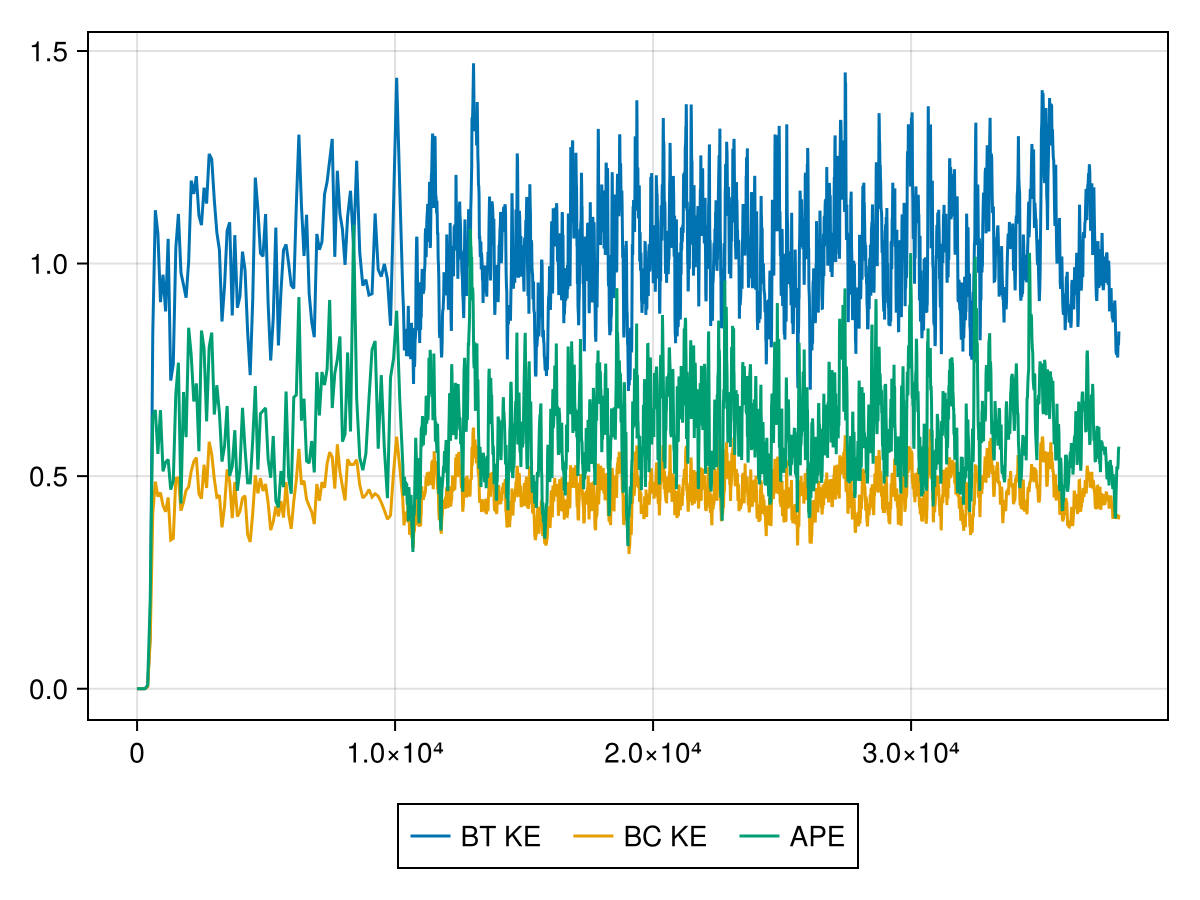

In [41]:
f = Figure()
ax = Axis(f[1,1])
lines!(ax, times, KE_bt, label="BT KE")
lines!(ax, times, KE_bc, label="BC KE")
lines!(ax, times, params.F * APE, label="APE")
#lines!(ax, times, params.F * APE + KE_bt + KE_bc, label="APE")
Legend(f[2,1], ax, orientation=:horizontal)
#lines!(ax, t, KE_1 + KE_2 + PE)
f

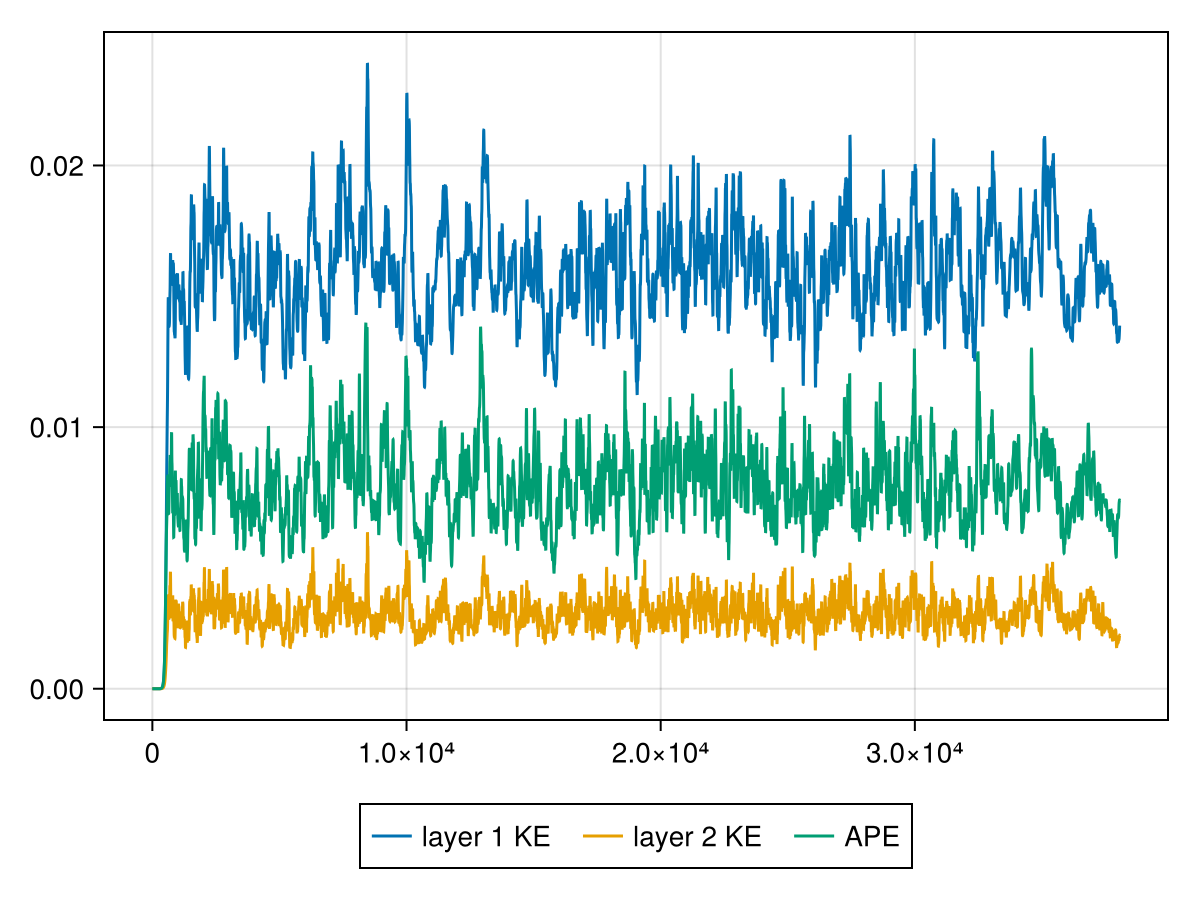

In [6]:
t = diag_file["diagnostics/kinetic_energy/t"]
KE = diag_file["diagnostics/kinetic_energy/data"]
PE = diag_file["diagnostics/potential_energy/data"]
KE_1 = map(E -> E[1], KE)
KE_2 = map(E -> E[2], KE)
KE_T = 
f = Figure()
ax = Axis(f[1,1])
lines!(ax, t, KE_1, label="layer 1 KE")
lines!(ax, t, KE_2, label="layer 2 KE")
lines!(ax, t, PE, label="APE")
Legend(f[2,1], ax, orientation=:horizontal)
#lines!(ax, t, KE_1 + KE_2 + PE)
f

In [56]:
include("AnalysisUtils.jl")
#data_directory = "/scratch/nad9961/swqg/59389740/7/"
data_directory = "/scratch/nad9961/swqg/58025661/20/"
Nqg_snaps = count_key_snapshots(data_directory, "qgsw")
grid = TwoDGrid(; nx=512, Lx=2π)
times = zeros(Nqg_snaps)
KE = zeros(Nqg_snaps)
APE   = zeros(Nqg_snaps)
for i=1:Nqg_snaps
    if (i % 100 == 1)
        println(i)
    end
    t, qh, ψh, uh, vh, Kd2 = load_qgswh_snapshot(data_directory, grid, i)
    KE[i] = parsevalsum(grid.Krsq .* abs2.(ψh), grid)
    APE[i]   = parsevalsum(abs2.(ψh), grid)
    times[i] = t
end

1
101
201
301
401
501
601
701


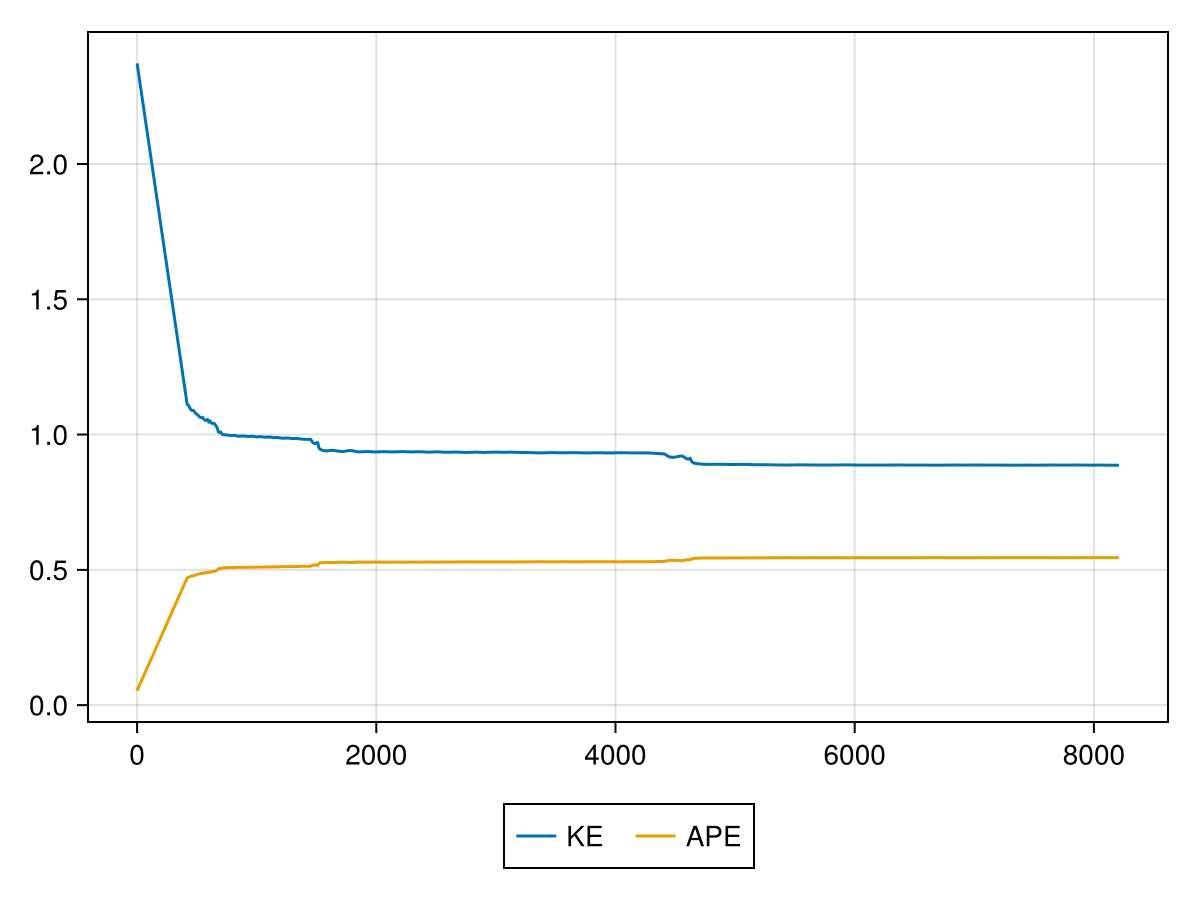

In [57]:
f = Figure()
ax = Axis(f[1,1])
lines!(ax, times, KE, label="KE")
lines!(ax, times, 3 * APE, label="APE")
#lines!(ax, times, params.F * APE + KE_bt + KE_bc, label="APE")
Legend(f[2,1], ax, orientation=:horizontal)
#lines!(ax, t, KE_1 + KE_2 + PE)
f

In [10]:
frames = keys(packet_file1["p/x/"])
x_follow = zeros(length(frames), 2)
k_follow = zeros(length(frames), 2)
idx = 1
for key=frames
    x_follow[idx,:] = packet_file1["p/x/" * key][1,:]
    k_follow[idx,:] = packet_file1["p/k/" * key][1,:]
    idx += 1
end

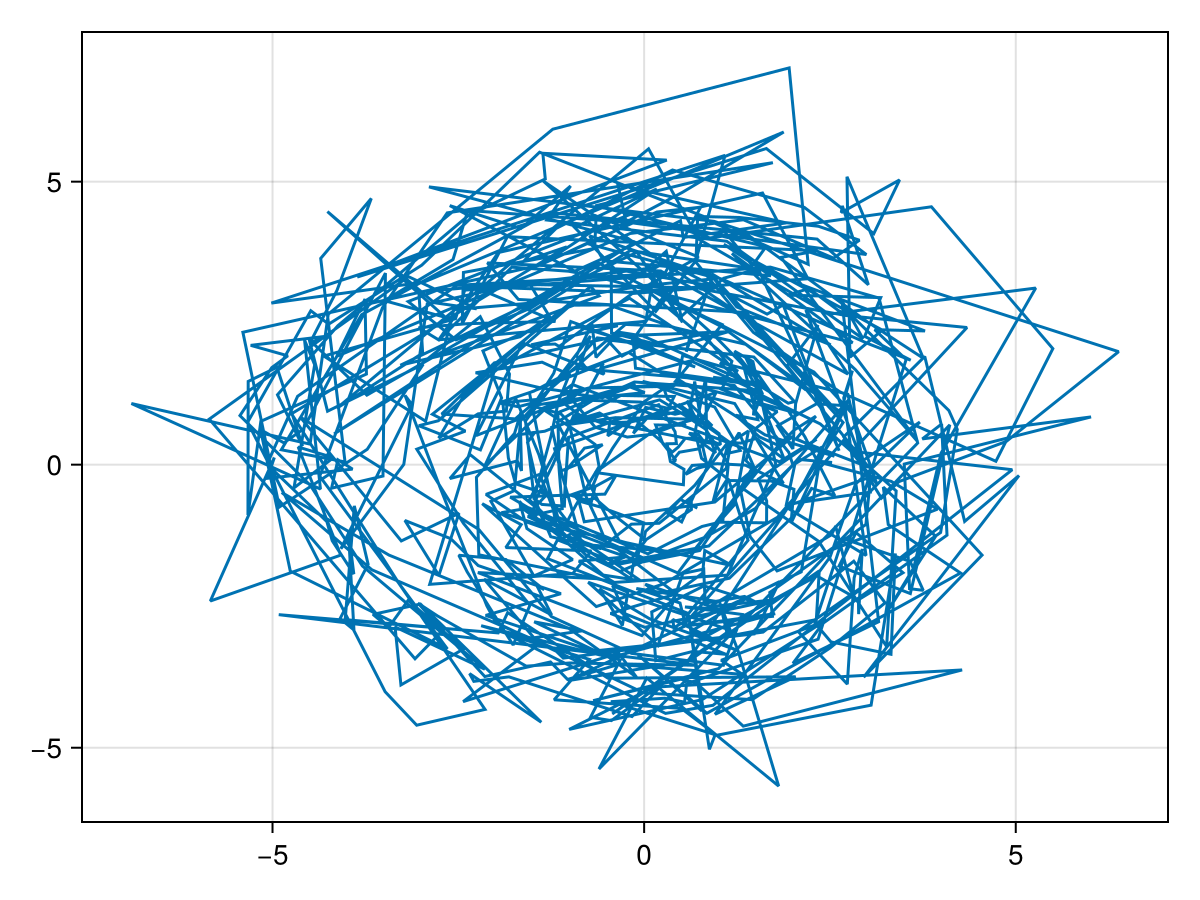

In [11]:
lines(k_follow[:,1], k_follow[:,2])

In [18]:
function linear_array_index(x, x_min, x_max, Nbins)
    return max(min(floor(Int, (x-x_min)/(x_max - x_min) * Nbins)+1, Nbins), 1)
end

function exponential_array_index(x, x_min, x_max, Nbins)
    return min(floor(Int, log(x/x_min) / log(x_max / x_min) * Nbins)+1, Nbins)
end

function count_bins(x, index_function, bin_counts)
    bin_idx = index_function.(x)
    @views bin_counts[bin_idx] .+= 1
    return bin_counts
end

count_bins (generic function with 1 method)

In [96]:
ω_min = 1
ω_max = maximum(ω)
Nbins = 5000
bin_counts = zeros(Nbins)
bin_edges = @. ω_min .+ (ω_max - ω_min) * (0:Nbins)/Nbins
bin_size = 1/Nbins
bin_centers = bin_edges[1:end-1] .+ 0.5*bin_size
index_function(x) = linear_array_index(x, ω_min, ω_max, Nbins)

frames = keys(packet_file1["p/k"])
for key=frames
    ks = packet_file1["p/k/" * key]
    ω = sqrt.(1 .+ sum(ks.^2, dims=2))[:]
    count_bins(ω, index_function, bin_counts)
end
frames = keys(packet_file2["p/k"])
for key=frames
    ks = packet_file2["p/k/" * key]
    ω = sqrt.(1 .+ sum(ks.^2, dims=2))[:]
    count_bins(ω, index_function, bin_counts)
end

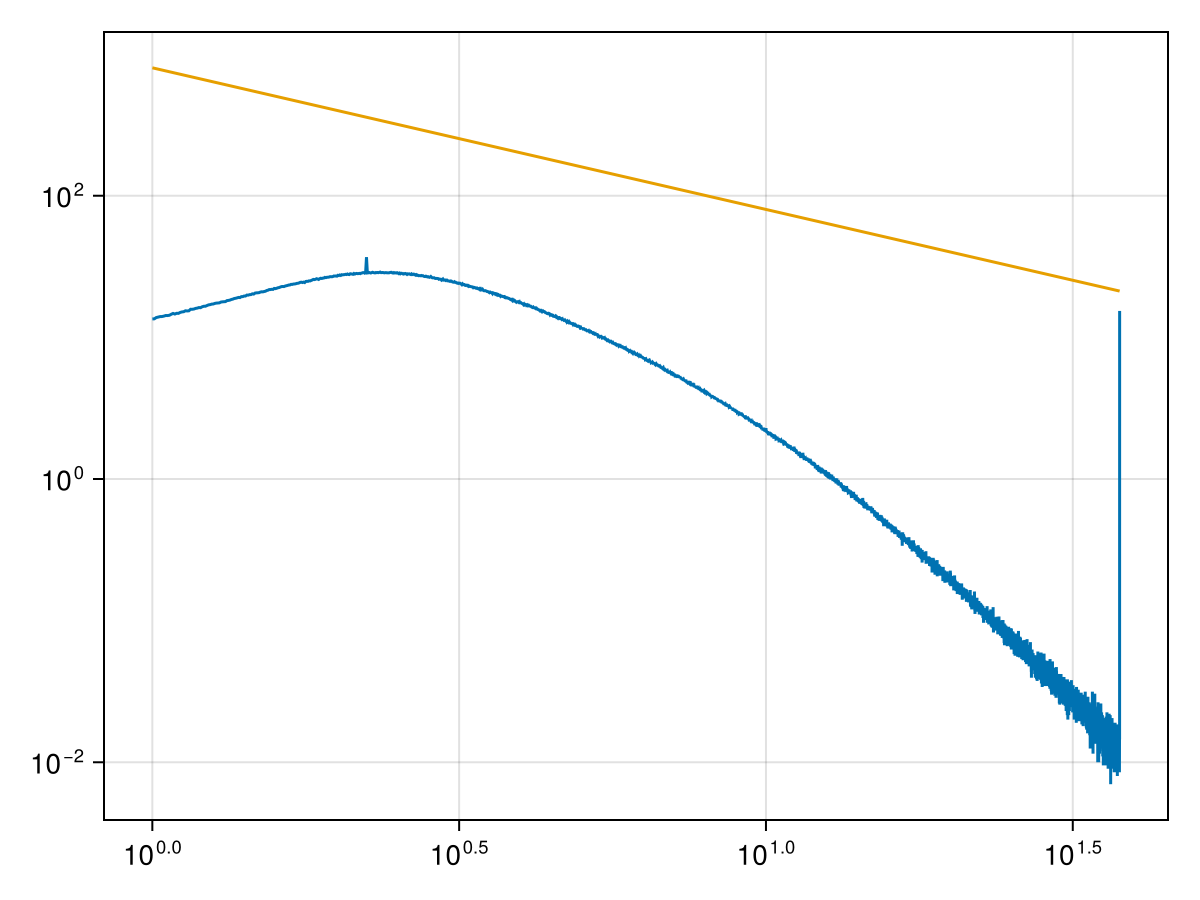

In [98]:
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10)
lines!(ax, bin_centers, replace(bin_counts, 0.0=>NaN) / 2000)
#lines!(ax, bin_centers, replace(bin_counts2, 0.0=>NaN))
#lines!(ax, bin_centers, 800*bin_centers.^(-0.35*log.(bin_centers)))
lines!(ax, bin_centers, 800*bin_centers.^(-1.0))
fig

### 